# ***Estimating Wireless Channels and Reconstructing BPSK Signals Using 3D-CNNs***

**3D CNN CODE WITH DEFINED DATASET**

In [25]:
import numpy as np
import pandas as pd

# ----------------------------
# Parameters
N_SAMPLES = 2000      # number of sequences
SEQ_LEN = 8           # symbols per sequence

# ----------------------------
# Generate clean BPSK signals (target)
# BPSK: ±1, only I channel carries data; Q=0 initially
target_i = 2*np.random.randint(0,2,(N_SAMPLES, SEQ_LEN)) - 1
target_q = np.zeros_like(target_i)
target_iq = np.stack((target_i, target_q), axis=2)  # shape: (N_SAMPLES, SEQ_LEN, 2)

# ----------------------------
# Generate received signals with realistic fading and noise

# Random amplitude fading [0.3,1.0]
amplitude_fading = np.random.uniform(0.3, 1.0, size=(N_SAMPLES, SEQ_LEN))

# Random phase rotation [-pi/2, pi/2]
phase_shift = np.random.uniform(-np.pi/2, np.pi/2, size=(N_SAMPLES, SEQ_LEN))

# Additive Gaussian noise (std=0.7)
noise = np.random.normal(0, 0.3, size=(N_SAMPLES, SEQ_LEN, 2))

# Apply fading and phase rotation
received_i = amplitude_fading * (target_i * np.cos(phase_shift) - target_q * np.sin(phase_shift))
received_q = amplitude_fading * (target_i * np.sin(phase_shift) + target_q * np.cos(phase_shift))
received_iq = np.stack((received_i, received_q), axis=2) + noise

# ----------------------------
# Prepare DataFrame
columns = []
for i in range(SEQ_LEN):
    columns.append(f"I{i}")
    columns.append(f"Q{i}")

# Flatten for DataFrame
received_flat = received_iq.reshape(N_SAMPLES, -1)
target_flat = target_iq.reshape(N_SAMPLES, -1)

# Column names for DataFrame
target_columns = [f"{c}_t" for c in columns]
all_columns = columns + target_columns

# Concatenate received and target
data = np.hstack([received_flat, target_flat])
df = pd.DataFrame(data, columns=all_columns)

# ----------------------------
# Save Excel
df.to_excel("dataset_fixed.xlsx", index=False)
print("Challenging dataset with fading, phase, and noise saved as dataset_fixed.xlsx")


Challenging dataset with fading, phase, and noise saved as dataset_fixed.xlsx


Using device: cuda
Received shape: (2000, 8, 2)
Target shape: (2000, 8, 2)
CNN3D(
  (conv1): Conv3d(2, 32, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(32, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(64, 32, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
  (bn3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(32, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
  (dropout): Dropout3d(p=0.1, inplace=False)
)
Epoch 1/200, Loss=0.251346
Epoch 10/200, Loss=0.197978
Epoch 20/200, Loss=0.178985
Epoch 30/200, Loss=0.160450
Epoch 40/200, Loss=0.144560
Epoch 50/200, Loss=0.131685
Epoch 60/200, Loss=0.125148
Epoch 70/200, Loss=0.114436
Epoch 80/200, Loss=0.112698
Epoch 90/20

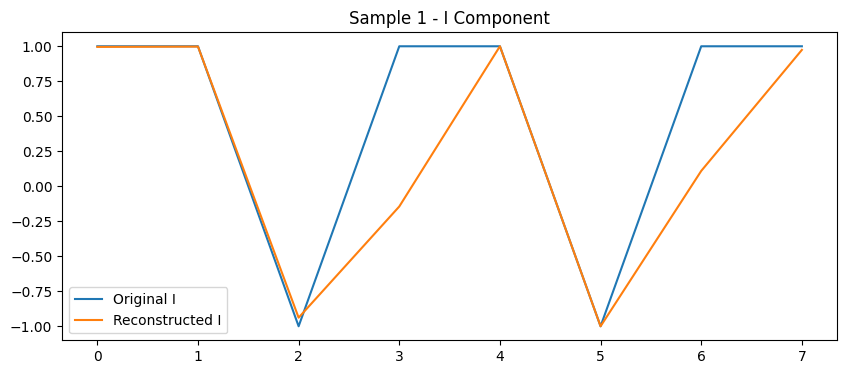

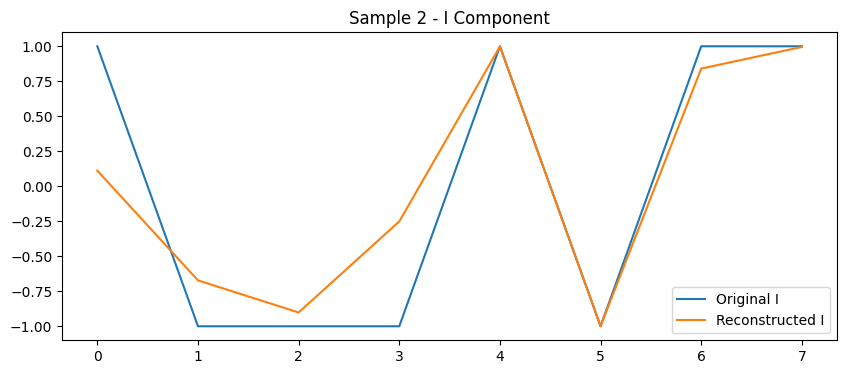

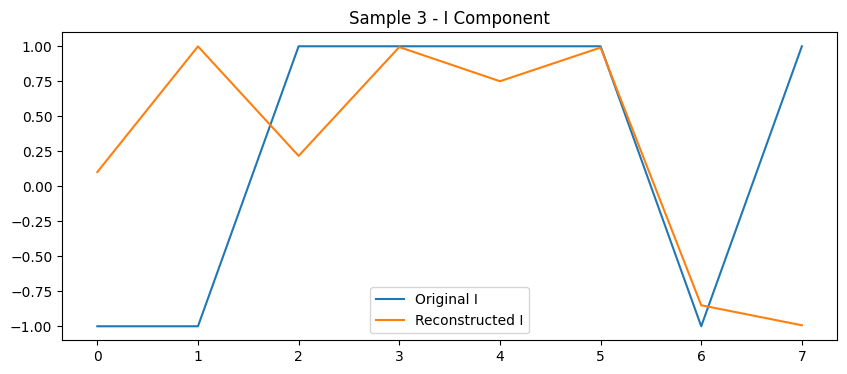

In [26]:
# 1️⃣ Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------------
# 2️⃣ Load Dataset from Excel
df = pd.read_excel("dataset_fixed.xlsx")

received_cols = [col for col in df.columns if "_t" not in col]
target_cols = [col for col in df.columns if "_t" in col]

received = df[received_cols].values.astype(np.float32)
target = df[target_cols].values.astype(np.float32)

N_SAMPLES = received.shape[0]
SEQ_LEN = received.shape[1] // 2  # 2 channels: I/Q

# Reshape to [N_samples, SEQ_len, 2]
received = received.reshape(N_SAMPLES, SEQ_LEN, 2)
target = target.reshape(N_SAMPLES, SEQ_LEN, 2)

print("Received shape:", received.shape)
print("Target shape:", target.shape)

# ---------------------------------------------------------
# 3️⃣ Dataset & DataLoader
class SignalDataset(Dataset):
    def __init__(self, x, y):
        # Permute to [batch, channels=2, depth=1, height=1, width=SEQ_LEN] for Conv3D
        self.x = torch.tensor(x, dtype=torch.float32).permute(0,2,1).unsqueeze(2).unsqueeze(3)
        self.y = torch.tensor(y, dtype=torch.float32).permute(0,2,1).unsqueeze(2).unsqueeze(3)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Split train/test
train_ratio = 0.8
train_size = int(N_SAMPLES * train_ratio)
dataset = SignalDataset(received, target)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, N_SAMPLES - train_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ---------------------------------------------------------
# 4️⃣ 3D-CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(2, 32, kernel_size=(1,1,3), padding=(0,0,1))
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(1,1,3), padding=(0,0,1))
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 32, kernel_size=(1,1,3), padding=(0,0,1))
        self.bn3 = nn.BatchNorm3d(32)
        self.conv4 = nn.Conv3d(32, 2, kernel_size=(1,1,3), padding=(0,0,1))
        self.dropout = nn.Dropout3d(0.1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.tanh(self.conv4(x))  # output in [-1,1]
        return x

model = CNN3D().to(device)
print(model)

# ---------------------------------------------------------
# 5️⃣ Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# ---------------------------------------------------------
# 6️⃣ Training Loop
EPOCHS = 200
loss_list = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    loss_list.append(avg_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss={avg_loss:.6f}")

# ---------------------------------------------------------
# 7️⃣ Evaluation
def calculate_ber(orig, recon):
    orig_bits = (orig > 0).astype(int)
    recon_bits = (recon > 0).astype(int)
    return np.sum(orig_bits != recon_bits) / orig_bits.size

model.eval()
all_orig = []
all_recon = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        output = output.cpu().squeeze(2).squeeze(2).permute(0,2,1).numpy()
        y_batch = y_batch.cpu().squeeze(2).squeeze(2).permute(0,2,1).numpy()
        all_orig.append(y_batch)
        all_recon.append(output)

all_orig = np.vstack(all_orig)
all_recon = np.vstack(all_recon)

nmse = np.mean((all_recon - all_orig)**2) / np.mean(all_orig**2)
ber = calculate_ber(all_orig, all_recon)
accuracy = np.mean(np.abs(all_recon - all_orig) < 0.1) * 100
evm = np.sqrt(np.mean((all_recon - all_orig)**2)) / np.sqrt(np.mean(all_orig**2)) * 100

print(f"\n✅ Final Metrics:")
print(f"NMSE={nmse:.6f}, BER={ber:.6f}, Accuracy={accuracy:.2f}%, EVM={evm:.2f}%")

# ---------------------------------------------------------
# 8️⃣ Plot Examples
for i in range(min(3, all_orig.shape[0])):
    plt.figure(figsize=(10,4))
    plt.plot(all_orig[i,:,0], label="Original I")
    plt.plot(all_recon[i,:,0], label="Reconstructed I")
    plt.legend()
    plt.title(f"Sample {i+1} - I Component")
    plt.show()


In [ ]:
To save the output and pngs

In [27]:
import os

# Save reconstructed outputs
output_folder = "reconstructed_outputs"
os.makedirs(output_folder, exist_ok=True)  # create folder if it doesn't exist

# Save as Excel
recon_df = pd.DataFrame(
    all_recon.reshape(all_recon.shape[0], -1),
    columns=[f"I{i}" if j%2==0 else f"Q{i}" for i in range(SEQ_LEN) for j in range(2)]
)
recon_df.to_excel(os.path.join(output_folder, "reconstructed_signals.xlsx"), index=False)
print(f"Reconstructed signals saved in folder '{output_folder}'")



import os

#  Save reconstructed outputs
output_folder = "reconstructed_outputs"
os.makedirs(output_folder, exist_ok=True)  # create folder if it doesn't exist

# Save as Excel
recon_df = pd.DataFrame(
    all_recon.reshape(all_recon.shape[0], -1),
    columns=[f"I{i}" if j%2==0 else f"Q{i}" for i in range(SEQ_LEN) for j in range(2)]
)
recon_df.to_excel(os.path.join(output_folder, "reconstructed_signals.xlsx"), index=False)
print(f" Reconstructed signals saved in folder '{output_folder}'")


Reconstructed signals saved in folder 'reconstructed_outputs'
 Reconstructed signals saved in folder 'reconstructed_outputs'


In [31]:
import os
import matplotlib.pyplot as plt

# Create folder for plots
plot_folder = "reconstructed_plots"
os.makedirs(plot_folder, exist_ok=True)

# Save first 3 waveforms as PNG
for i in range(min(3, all_orig.shape[0])):
    plt.figure(figsize=(10,4))
    plt.plot(all_orig[i,:,0], label="Original I")
    plt.plot(all_recon[i,:,0], label="Reconstructed I")
    plt.legend()
    plt.title(f"Sample {i+1} - I Component")

    # Save as PNG
    png_path = os.path.join(plot_folder, f"sample_{i+1}_I.png")
    plt.savefig(png_path)
    plt.close()  # close to free memory


In [32]:
!zip -r project_archive.zip dataset_fixed.xlsx reconstructed_outputs reconstructed_plots
from google.colab import files
files.download("project_archive.zip")


updating: dataset_fixed.xlsx (deflated 4%)
updating: reconstructed_outputs/ (stored 0%)
updating: reconstructed_outputs/reconstructed_signals.xlsx (deflated 0%)
  adding: reconstructed_plots/ (stored 0%)
  adding: reconstructed_plots/sample_2_I.png (deflated 5%)
  adding: reconstructed_plots/sample_1_I.png (deflated 5%)
  adding: reconstructed_plots/sample_3_I.png (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>